# Info
Name:  

    TCAP_cloud

Purpose:  

    To compare the various cloud properties retrieved via different methods from TCAP.
    Looking at the Feb, 19th, 2013 case
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - load_utils.py : for loading modis files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - math
    - os
    - gc
    - pdb
    - datetime
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 20151117_zen_cld_retrieved.mat: cloud retrieval file
  - MYD06_L2.A2015321.1540.006.2015322185040.hdf: MODIS file
  
Modification History:

    Written: Samuel LeBlanc, NASA Ames, Santa Cruz, CA, 2016-04-06
    Modified: 

# Import initial modules and default paths


In [2]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import hdf5storage as hs
import load_utils as lm
import os

In [3]:
from mpl_toolkits.basemap import Basemap,cm

In [4]:
import write_utils as wu
import plotting_utils as pu
import map_utils as mu
import Run_libradtran as RL

In [5]:
%matplotlib notebook

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [6]:
# set the basic directory path
fp='C://Users//sleblan2//Research//TCAP//'

# Load the various data

## Verify the retrievals from 4STAR

### Build the proper lut from the idl out file

In [7]:
vv = 'v1'

In [8]:
# load the idl save file containing the modeled radiances
s = sio.idl.readsav(fp+'model/sp_v1_20130219_4STAR.out')
print s.keys()
print 'sp', s.sp.shape
print 'sp (wp,   wvl,  z,  re,  ta)'

['tau', 'ab', 'pw', 'sp_irrdn', 'sp', 'zenlambda', 'sza', 'zout', 'sp_irrup', 'z', 'ref']
sp (2L, 1556L, 2L, 35L, 24L)
sp (wp,   wvl,  z,  re,  ta)


### Compare to lut from NAAMES

In [9]:
fp_lut_mat = 'C:\\Users\\sleblan2\\Research\\NAAMES\\lut\\v2_NAAMES_lut.mat'
print('Loading the lut file:{}'.format(fp_lut_mat))
if not os.path.isfile(fp_lut_mat):
    print('File {} does not exist'.format(fp_lut_mat))
    raise IOError('LUT File not found: {}'.format(fp_lut_mat))
luts = hs.loadmat(fp_lut_mat)

Loading the lut file:C:\Users\sleblan2\Research\NAAMES\lut\v2_NAAMES_lut.mat


Exception in thread Thread-3:
Traceback (most recent call last):
  File "C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\threading.py", line 810, in __bootstrap_inner
    self.run()
  File "C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\parentpoller.py", line 104, in run
    interrupt_main()
  File "C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\dummy_thread.py", line 142, in interrupt_main
    raise KeyboardInterrupt
KeyboardInterrupt



In [22]:
luts.keys()

[u'tau',
 u'rad',
 u'sza',
 u'irr_dn_diff',
 u'irr_dn',
 u'zout',
 u'wvl',
 u'phase',
 u'ref',
 u'irr_up']

In [23]:
luts['irr_up'].shape

(2L, 1302L, 3L, 34L, 29L, 15L)

In [27]:
luts['rad'].shape, s.sp.shape

((2L, 1302L, 3L, 34L, 29L, 15L), (2L, 1556L, 2L, 35L, 24L))

In [28]:
s.sp[:,:,:,:,:,np.newaxis].shape

(2L, 1556L, 2L, 35L, 24L, 1L)

In [38]:
s.ref

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  20.,  22.,  23.,  25.,  28.,
        30.,  32.,  35.,  38.,  40.,  43.,  45.,  48.,  50.,  52.,  55.,
        58.,  60.], dtype=float32)

In [39]:
luts['ref']

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,  30.,
        33.,  35.,  38.,  40.,  43.,  45.,  48.,  50.,  53.,  55.,  58.,
        60.])

### reshape TCAP LUT to fit NAAMES format and save new file

In [54]:
tcap_lut = {u'tau':s.tau,
            u'rad':s.sp[:,:,:,:,:,np.newaxis],
            u'sza':np.array(s.sza)[np.newaxis],
            u'irr_dn_diff':s.sp_irrdn[:,:,:,:,:,np.newaxis]*0.0,
            u'irr_dn':s.sp_irrdn[:,:,:,:,:,np.newaxis],
            u'irr_up':s.sp_irrup[:,:,:,:,:,np.newaxis],
            u'zout':s.zout,
            u'wvl':s.zenlambda,
            u'phase':['wc','ic'],
            u'ref':s.ref}

In [55]:
hs.savemat(fp+'model\\{}_TCAP_lut.mat'.format(vv),tcap_lut)

### Run the retrieval via the run_zen_cld_retrieval command line
in the python_codes directory:

> python Run_zen_cld_retrieval.py -lut C:\Users\sleblan2\Research\TCAP\model\v1_TCAP_lut.mat C:\Users\sleblan2\Research\TCAP\20130219starzen.mat -o C:\Users\sleblan2\Research\TCAP\plots\ 

## Check the 4STAR data

In [8]:
ss = sio.loadmat(fp+'20130219starzen.mat')

In [13]:
ss.keys()

['Str',
 'sza',
 'm_ray',
 'toggle',
 'pitch',
 'Tst',
 'fwhm',
 'nirt',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'nirheader',
 'iset',
 'sd_aero_crit',
 'nirTint_rad',
 'dark',
 'nirVdettemp',
 'Elstep',
 'nircols',
 'sunaz',
 'O3col',
 'nirfilen',
 'f',
 'flagallcolsitems',
 't',
 'c0mod',
 'flagallcols',
 'rate',
 'program_version',
 'sat_time',
 'sat_set_vis',
 'visheader',
 'nirTint',
 'filename',
 'rads',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'visAVG',
 'Zn',
 'AZstep',
 't_rad',
 'darkstd',
 'QdVtot',
 'nirAVG',
 'w',
 'ELcorr',
 'sat_nir',
 'visVdettemp_C',
 'El_deg',
 'skyresp',
 'Lon',
 'AZ_deg',
 'visrow_labels',
 'm_H2O',
 'c0err',
 'viscols',
 'visTint_rad',
 'sat_vis',
 'flagitems',
 'aerosolcols',
 'vissat_pixel',
 'flag',
 'visfilen',
 'c0',
 'Tprecon_C',
 'raw',
 '__header__',
 'rawcorr',
 'sat_ij',
 'sunel',
 'visTint',
 'Tbox_C',
 'QdVtb',
 'rad',
 'QdVlr',
 'nirVdettemp_C',
 'visVdettemp',
 'nirrow_labels',
 'm_aero',
 'Tbox',
 'Tprecon',
 'ng',
 'note',
 'R

In [14]:
ss['t'].shape

(3297L, 1L)

In [15]:
ss['rad'].shape

(3297L, 1556L)

<IPython.core.display.Javascript object>


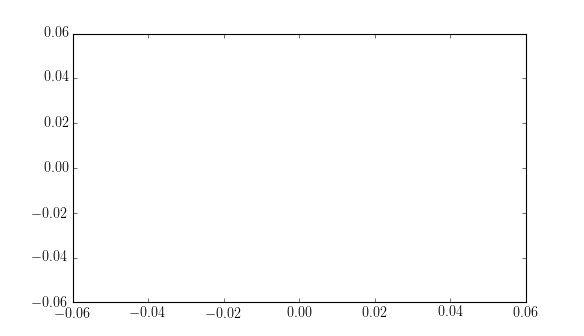

In [16]:
plt.figure()
plt.plot(ss['t'],ss['rad'][:,400])

## Load the retrieved cloud properties from 4STAR

In [9]:
star = hs.loadmat(fp+'4STAR//20130219_zen_cld_retrieved.mat')

In [10]:
star.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

<IPython.core.display.Javascript object>


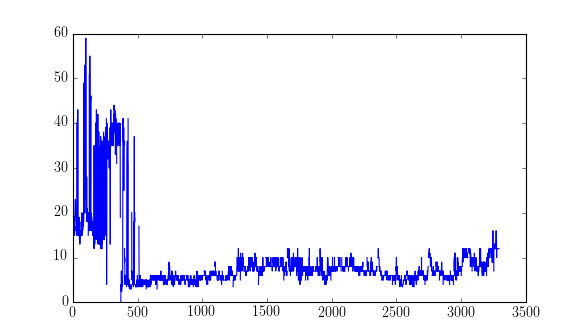

In [11]:
plt.figure()
plt.plot(star['tau'])

<IPython.core.display.Javascript object>


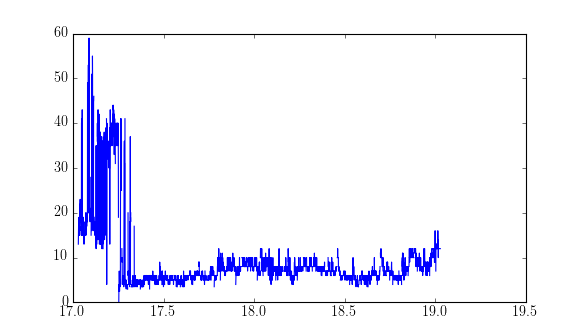

In [11]:
plt.figure()
plt.plot(star['utc'],star['tau'])

In [13]:
star['ref'] = Sp.smooth(star['ref'],20)

<IPython.core.display.Javascript object>


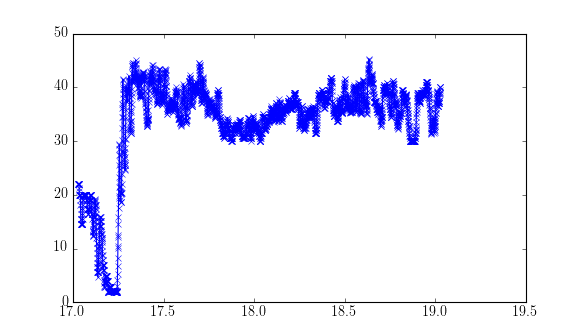

In [14]:

plt.figure()
plt.plot(star['utc'],star['ref'],'x-')



## Load the important MODIS files

In [12]:
myd06_file = fp+'MODIS\\MYD06_L2.A2013050.1725.006.2014260074007.hdf'
myd03_file = fp+'MODIS\\MYD03.A2013050.1725.006.2013051163424.hdf'
print os.path.isfile(myd03_file) #check if it exists
print os.path.isfile(myd06_file)

True
True


In [13]:
import load_utils as lm
modis,modis_dicts = lm.load_modis(myd03_file,myd06_file)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

### Subset the MODIS values to match the flight path

In [14]:
import map_utils as mu

In [15]:
mod_ind = mu.map_ind(modis['lon'],modis['lat'],star['lon'],star['lat'])

Running through flight track: [########################################]100% -- Done! 


### Now compare MODIS vs. 4STAR with bean plots


In [16]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


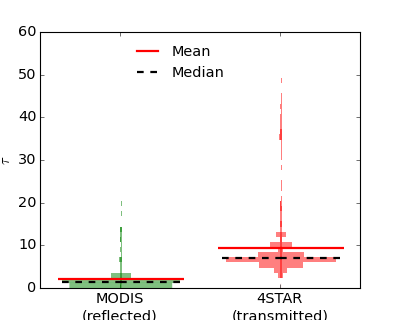

In [55]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['tau'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['tau'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_COD_bean_modis_4star.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


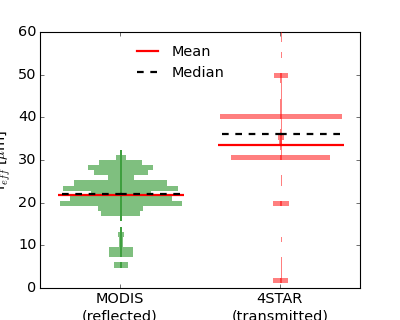

In [56]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['ref'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['ref'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_ref_bean_modis_4star.png',transparent=True,dpi=600)

# Save to ict files

## Save the ict file for 4STAR cloud data

In [17]:
d_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':star['tau'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth of the cloud above the Aircraft'},
          'REF':{'data':star['ref'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':star['phase'],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud above, 0: pure liquid cloud, 1: pure ice cloud, mixed phase not retrieved'},
          'LAT':{'data':star['lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position latitude (North positive)'},
          'LON':{'data':star['lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position longitude (East positive)'},
          'ALT':{'data':star['alt'],'unit':'meter','format':'.1f',
                 'long_description':'Aircraft altitude'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [18]:
h_dict ={'PI':'Jens Redemann',
         'Institution':'NASA Ames Research Center',
         'Instrument':'4STAR',
         'campaign':'TCAP #1',
         'special_comments':'Preliminary retrieved cloud properties data',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"centered at Cape Cod, Massachussetts, actual location of DOE G-1 described by lat and lon below",
         'instrument_info':'Retrieved products from the 4STAR zenith radiance measurements',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':1.0,
         'uncertainty':'Preliminary 7% in REF and 5% in COD',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'TCAP field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: preliminary retrieved values, may be subject to multiple errors
    including due to clouds influencing presumed surface albedo, non-homogeneous clouds, or mixed phase clouds"""
        }

In [19]:
order=['LAT','LON','ALT','SZA','COD','REF','PHASE']

In [20]:
data_dict = wu.prep_data_for_ict(d_dict,time_interval=1.0)

In [21]:
data_dict.keys()

['Start_UTC', 'SZA', 'LON', 'LAT', 'COD', 'PHASE', 'ALT', 'REF']

<IPython.core.display.Javascript object>


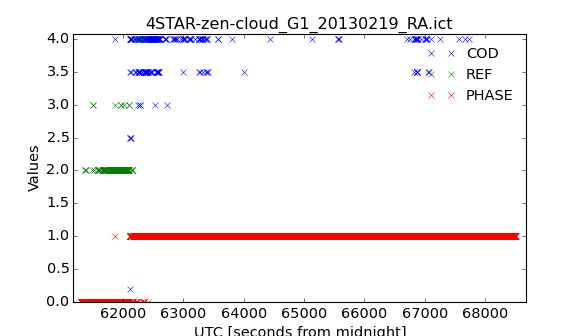

plotting the togethers


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


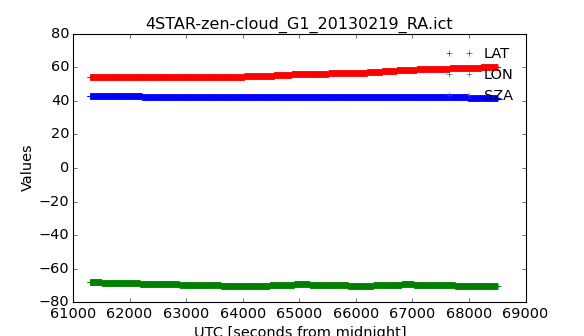

plotting the togethers 2


<IPython.core.display.Javascript object>


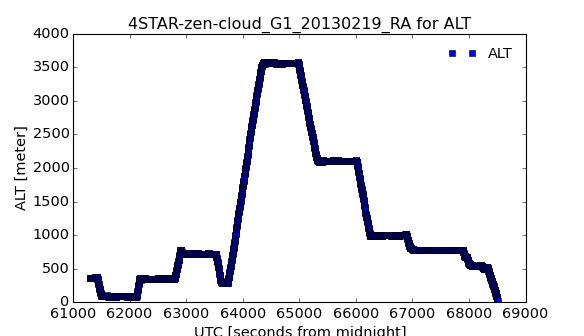

plotting ALT


In [47]:
wu.make_plots_ict(data_dict,filepath=fp+'plots/',data_id='4STAR-zen-cloud',loc_id='G1',date='20130219',rev='RA',
                  plot_together=['COD','REF','PHASE'],plot_together2=['LAT','LON','SZA'])

In [22]:
wu.write_ict(h_dict,data_dict,filepath=fp,data_id='4STAR-zen-cloud',loc_id='G1',date='20130219',rev='RA',order=order)

LAT
LON
ALT
SZA
COD
REF
PHASE
File writing successful to: C://Users//sleblan2//Research//TCAP//4STAR-zen-cloud_G1_20130219_RA.ict


## Save the ICT file for the MODIS cloud properties

In [23]:
md_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':modis['tau'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':modis['ref'][mod_ind[0,:],mod_ind[1,:]],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':modis['phase'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':modis['lat'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':modis['lon'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [24]:
mh_dict ={'PI':'Samuel LeBlanc',
         'Institution':'NASA Ames Research Center',
         'Instrument':'MODIS',
         'campaign':'TCAP #1',
         'special_comments':'MODIS retrieved cloud values linked along the DOE G1 flight path',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'G1',
         'location':"Centered at Cape Cod, Massachussetts, actual location of DOE G1 described by lat and lon below",
         'instrument_info':'Retrieved products from the MODIS, MYD06_L2.A2015321.1540.006.2015322185040.hdf',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':1.0,
         'uncertainty':'N\A',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'TCAP field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: initial go at this, for radiative transfer calculations"""
        }

In [25]:
order=['LAT','LON','SZA','COD','REF','PHASE']

In [26]:
mdata_dict = wu.prep_data_for_ict(md_dict,time_interval=1.0)

In [30]:
wu.write_ict(mh_dict,mdata_dict,filepath=fp,data_id='MODIS-cloud-to-G1',loc_id='G1',date='20130219',rev='RA',order=order)

LAT
LON
SZA
COD
REF
PHASE
File writing successful to: C://Users//sleblan2//Research//TCAP//MODIS-cloud-to-G1_G1_20130219_RA.ict


# Prepare input files for radiative transfer


In [27]:
import Run_libradtran as Rl

## Prepare the defaults

In [32]:
from datetime import datetime
datetime(2013,02,19).timetuple().tm_yday

50

In [55]:
geo = {'lat':47.6212167,'lon':52.74245,'doy':50,'zout':[0,100.0]}
aero = {} # none
cloud = {'ztop':10.5,'zbot':10.0,'write_moments_file':False}
source = {'wvl_range':[201.0,4000.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':'/u/sleblan2/libradtran/libRadtran-2.0-beta/data/'}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':10.0}

In [56]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0

In [57]:
phase_star = {0:'wc',1:'ic'}

In [58]:
phase_modis = {0:'wc',1:'wc',2:'ic',3:'ic',6:'wc'}

## Create input files for 4STAR measurements

In [59]:
# open the list file
f = open(fp+'rtm/TCAP_20130219_CRE.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/TCAP_CRE_20130219/'
fpp_out = '/nobackup/sleblan2/rtm/output/TCAP_CRE_20130219/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [60]:
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'TCAP_v1_star_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,data_dict['LON']['data'][i],data_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = data_dict['COD']['data'][i],data_dict['REF']['data'][i]
    cloud['phase'] = phase_star[data_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'TCAP_v1_star_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
f.close()

3
wvl_range starting too low, setting to 250 nm
5
7
9
12
14
16
18
21
23
25
27
30
32
34
36
39
41
43
45
48
50
52
54
57
59
61
63
66
73
75
77
80
82
84
86
89
91
93
95
98
100
102
104
107
109
111
113
116
118
120
122
125
127
134
136
139
141
143
145
148
150
152
154
157
159
161
163
166
168
170
172
175
177
179
181
184
186
188
195
198
200
202
204
207
209
211
213
216
218
220
222
225
227
229
231
234
236
238
240
243
245
247
249
256
259
261
263
265
268
270
272
274
277
279
281
283
286
288
290
292
295
297
299
301
304
306
308
310
318
320
322
324
327
329
331
333
336
338
340
342
345
347
349
351
354
356
358
360
363
365
367
369
372
379
381
383
386
388
390
392
395
397
399
401
404
406
408
410
413
415
417
419
422
424
426
428
431
433
440
442
445
447
449
451
454
456
458
460
463
465
467
469
472
474
476
478
481
483
485
487
490
492
494
501
504
506
508
510
513
515
517
519
522
524
526
528
531
533
535
537
540
542
544
546
549
551
553
555
562
565
567
569
571
574
576
578
580
583
585
587
589
592
594
596
598
601
603
605
607

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


## Create input files for MODIS clouds

In [61]:
# open the list file
fm = open(fp+'rtm/TCAP_20130219_CRE_modis.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/TCAP_CRE_20130219/'
fpp_out = '/nobackup/sleblan2/rtm/output/TCAP_CRE_20130219/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [62]:
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'TCAP_v1_modis_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,mdata_dict['LON']['data'][i],mdata_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = mdata_dict['COD']['data'][i],mdata_dict['REF']['data'][i]
    cloud['phase'] = phase_modis[mdata_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'TCAP_v1_modis_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

0
1
3
5
7
9
12
14
16
18
21
23
25
27
30
32
34
36
39
41
43
45
48
50
52
54
57
59
61
63
66
68
70
71
73
75
77
80
82
84
86
89
91
93
95
98
100
102
104
107
109
111
113
116
118
120
122
125
127
129
131
133
134
136
139
141
143
145
148
150
152
154
157
159
161
163
166
168
170
172
175
177
179
181
184
186
188
190
193
194
195
198
200
254
255
256
259
261
263
265
268
270
272
274
277
279
281
283
286
288
290
292
299
301
304
345
347
349
351
354
356
358
360
363
365
367
369
372
374
376
378
379
381
383
386
388
390
392
395
397
399
401
404
406
435
490
492
494
496
499
500
501
504
506
508
510
513
515
517
519
522
524
526
528
560
561
562
565
567
569
571
574
576
578
580
614
616
619
621
622
624
673
675
678
680
682
684
685
687
689
692
694
696
698
701
703
705
707
710
712
714
716
719
721
723
725
728
730
732
734
737
739
741
743
745
746
748
751
753
755
757
760
762
764
766
769
771
773
775
778
780
782
784
787
789
791
793
796
798
800
802
805
806
807
810
812
823
830
832
834
837
839
841
843
846
848
850
852
855
857
859
868
871


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


# Run the libradtran runs on the pleiades

Go to folder on this computer and run the rsync: (make sure the fodler is created on bridge)
> rsync -auzvb ./ bridge:/nobackup/sleblan2/rtm/input/TCAP_CRE_20130219/

Then logon to pleaides and run this command in the correct folder

> sed -i -- 's$C://Users//sleblan2//Research//TCAP//rtm/input/CRE/$/nobackup/sleblan2/rtm/input/TCAP_CRE_20130219$g' *.dat

Make sure the list files are put in as always

> scp *.sh bridge:~/TCAP/runs/

Once copied, run the files

> ~/TCAP/runs> ./TCAP_20130219_CRE.sh
> ~/TCAP/runs> ./TCAP_20130219_CRE_modis.sh

After copy the results to your homw computer

# Read the output from libradtran

## Read the out files

In [28]:
nstar = len(data_dict['LAT']['data'])
nmodis = len(mdata_dict['LAT']['data'])
star_CRE = {'dn':np.zeros((nstar,2))+np.nan,'up':np.zeros((nstar,2))+np.nan}
star_CRE_clear = {'dn':np.zeros((nstar,2))+np.nan,'up':np.zeros((nstar,2))+np.nan}
modis_CRE = {'dn':np.zeros((nmodis,2))+np.nan,'up':np.zeros((nmodis,2))+np.nan}
modis_CRE_clear = {'dn':np.zeros((nmodis,2))+np.nan,'up':np.zeros((nmodis,2))+np.nan}
star_C = np.zeros((nstar,2))+np.nan
modis_C = np.zeros((nmodis,2))+np.nan

In [31]:
print 'MODIS'
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print '\r{}..'.format(i)
    try:
        f_in = 'TCAP_v1_modis_{:03d}.dat'.format(i)
        s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
        f_in = 'TCAP_v1_modis_{:03d}_clear.dat'.format(i)
        sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    except ValueError:
        print 'Problem with file at: {}'.format(i)
        continue
    
    modis_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    modis_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    modis_CRE['up'][i,:] = s['diffuse_up']
    modis_CRE_clear['up'][i,:] = sc['diffuse_up']
    modis_C[i,:] = (modis_CRE['dn'][i,:]-modis_CRE['up'][i,:]) - (modis_CRE_clear['dn'][i,:]-modis_CRE_clear['up'][i,:])

MODIS
0..
1..
3..
5..
7..
9..
12..
14..
16..
18..
21..
23..
25..
27..
30..
32..
34..
36..
39..
41..
43..
45..
48..
50..
52..
54..
57..
59..
61..
63..
66..
68..
70..
71..
73..
75..
77..
80..
82..
84..
86..
89..
91..
93..
95..
98..
100..
102..
104..
107..
109..
111..
113..
116..
118..
120..
122..
125..
127..
129..
131..
133..
134..
136..
139..
141..
143..
145..
148..
150..
152..
154..
157..
159..
161..
163..
166..
168..
170..
172..
175..
177..
179..
181..
184..
186..
188..
190..
193..
194..
195..
198..
200..
254..
255..
256..
259..
261..
263..
265..
268..
270..
272..
274..
277..
279..
281..
283..
286..
288..
290..
292..
299..
301..
304..
345..
347..
349..
351..
354..
356..
358..
360..
363..
365..
367..
369..
372..
374..
376..
378..
379..
381..
383..
386..
388..
390..
392..
395..
397..
399..
401..
404..
406..
435..
490..
492..
494..
496..
499..
500..
501..
504..
506..
508..
510..
513..
515..
517..
519..
522..
524..
526..
528..
560..
561..
562..
565..
567..
569..
571..
574..
576..
578..
58

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [38]:
print '4STAR'
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print '\r{}..'.format(i)
    try:
        f_in = 'TCAP_v1_star_{:03d}.dat'.format(i)
        s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
        f_in = 'TCAP_v1_star_{:03d}_clear.dat'.format(i)
        sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    except ValueError:
        print 'Problem with file at: {}'.format(i)
        continue
    except IOError:
        continue
        
    star_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    star_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    star_CRE['up'][i,:] = s['diffuse_up']
    star_CRE_clear['up'][i,:] = sc['diffuse_up']
    star_C[i,:] = (star_CRE['dn'][i,:]-star_CRE['up'][i,:]) - (star_CRE_clear['dn'][i,:]-star_CRE_clear['up'][i,:])

4STAR
3..
5..
7..
9..
12..
14..
16..
18..
21..
23..
25..
27..
30..
32..
34..
36..
39..
41..
43..
45..
48..
50..
52..
54..
57..
59..
61..
63..
66..
73..
75..
77..
80..
82..
84..
86..
89..
91..
93..
95..
98..
100..
102..
104..
107..
109..
111..
113..
116..
118..
120..
122..
125..
127..
134..
136..
139..
141..
143..
145..
148..
150..
152..
154..
157..
159..
161..
163..
166..
168..
170..
172..
175..
177..
179..
181..
184..
186..
188..
195..
198..
200..
202..
204..
207..
209..
211..
213..
216..
218..
220..
222..
225..
227..
229..
231..
234..
236..
238..
240..
243..
245..
247..
249..
256..
259..
261..
263..
265..
268..
270..
272..
274..
277..
279..
281..
283..
286..
288..
290..
292..
295..
297..
299..
301..
304..
306..
308..
310..
318..
320..
322..
324..
327..
329..
331..
333..
336..
338..
340..
342..
345..
347..
349..
351..
354..
356..
358..
360..
363..
365..
367..
369..
372..
379..
381..
383..
386..
388..
390..
392..
395..
397..
399..
401..
404..
406..
408..
410..
413..
415..
417..
419..
4

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


## Double check the output

In [39]:
star_CRE

{'dn': array([[ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        ..., 
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan]]), 'up': array([[ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        ..., 
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan]])}

In [41]:
star_CRE['dn'][34]

array([ 203.4825    ,  822.53404123])

In [36]:
modis_CRE

{'dn': array([[ 183.4008    ,  822.43114177],
        [ 183.4035    ,  822.43884179],
        [          nan,           nan],
        ..., 
        [          nan,           nan],
        [          nan,           nan],
        [          nan,           nan]]),
 'up': array([[  11.81299,  540.8442 ],
        [  11.81316,  540.8483 ],
        [       nan,        nan],
        ..., 
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]])}

In [43]:
modis_C[34]

array([-389.17982   , -412.93661122])

## Plot the CRE

<IPython.core.display.Javascript object>


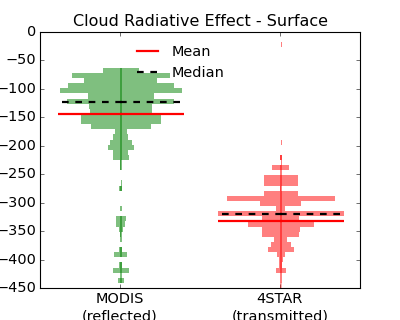

In [68]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-450,0],xlim=[-0.5,1.5])
ax1.set_ylabel('Cloud Radiative Effect [W/m$^2$]')
ax1.set_title('Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_C[:,0],0,[-450,0],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_C[:,0],1,[-450,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_surface_CRE_modis_4STAR.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


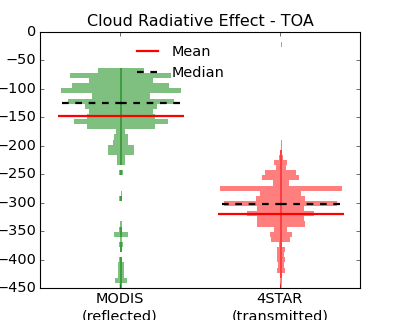

In [66]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-450,0],xlim=[-0.5,1.5])
ax1.set_ylabel('Cloud Radiative Effect [W/m$^2$]')
ax1.set_title('Cloud Radiative Effect - TOA')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_C[:,1],0,[-450,0],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_C[:,1],1,[-450,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_toa_CRE_modis_4STAR.png',transparent=True,dpi=600)

## Calculate the relative CRE (rCRE)

In [77]:
modis_rC = np.zeros_like(modis_C)
star_rC = np.zeros_like(star_C)

In [79]:
modis_rC[:,0] = modis_C[:,0]/modis_CRE['dn'][:,1]*100.0
star_rC[:,0] = star_C[:,0]/star_CRE['dn'][:,1]*100.0
modis_rC[:,1] = modis_C[:,1]/modis_CRE['dn'][:,1]*100.0
star_rC[:,1] = star_C[:,1]/star_CRE['dn'][:,1]*100.0

In [80]:
star_rC.shape

(7203L, 2L)

<IPython.core.display.Javascript object>


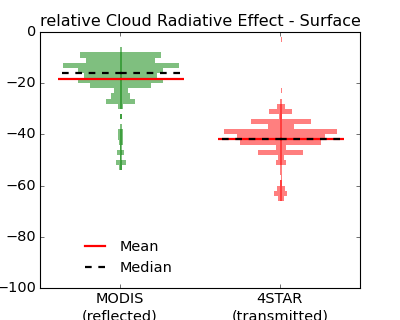

In [85]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,1.5])
ax1.set_ylabel('relative Cloud Radiative Effect [%]')
ax1.set_title('relative Cloud Radiative Effect - Surface')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_rC[:,0],0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_rC[:,0],1,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_surface_rCRE_modis_4STAR.png',transparent=True,dpi=600)

In [87]:
np.nanmean(modis_rC[:,0]),np.nanmean(star_rC[:,0])

(-18.244005874553931, -41.939818607877044)

In [88]:
np.nanstd(modis_rC[:,0]), np.nanstd(star_rC[:,0])

(9.2917558471330324, 7.3176603263279736)

<IPython.core.display.Javascript object>


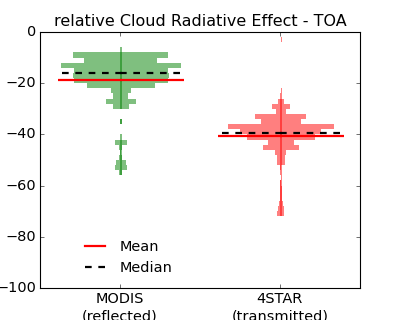

In [86]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[-100,0],xlim=[-0.5,1.5])
ax1.set_ylabel('relative Cloud Radiative Effect [%]')
ax1.set_title('relative Cloud Radiative Effect - TOA')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis_rC[:,1],0,[-100,0],legend=True,onlyhist=False,loc=4,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star_rC[:,1],1,[-100,0],legend=True,color='r',bins=50)
plt.savefig(fp+'plots/20130219_TOA_rCRE_modis_4STAR.png',transparent=True,dpi=600)

## Testing area

In [51]:
0.5*0.18065/0.001*3/2/7.8

17.37019230769231

In [54]:
mdata_dict['COD']['data'][5]

17.369999611750242

In [59]:
mdn_cl = 5.950567e+02+5.136170e+01
mup_cl = 4.183247e+01

In [60]:
mdn =  4.806639e+01+4.617782e+02
mup = 3.633226e+01

In [61]:
dn_cl = 5.950567e+02+5.136170e+01
up_cl = 4.183247e+01
dn = 1.840833e-02+3.051980e+02
up = 2.012267e+01

In [62]:
mnet = mdn-mup
mnet_cl = mdn_cl-mup_cl

In [63]:
mnet,mnet_cl,mnet-mnet_cl

(473.51233, 604.58593, -131.07359999999994)

In [64]:
net = dn-up
net_cl = dn_cl-up_cl
net,net_cl,net-net_cl

(285.09373832999995, 604.58593, -319.49219167)